Cell 1 : Trading & backtesting functions

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

def calculate_spread_zscore(stock_a, stock_b, window=30):
    stock_a_norm = stock_a / stock_a.iloc[0]
    stock_b_norm = stock_b / stock_b.iloc[0]
    spread = stock_a_norm - stock_b_norm
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()
    zscore = (spread - rolling_mean) / rolling_std
    return spread, zscore

def backtest_pairs_strategy(stock_a, stock_b, entry_threshold=2.0, exit_threshold=0.5):
    spread, zscore = calculate_spread_zscore(stock_a, stock_b)

    returns = []
    position = 0
    entry_price_a = 0
    entry_price_b = 0

    for i in range(len(zscore)):
        if i == 0:
            returns.append(0)
            continue

        if position == 0:
            if zscore.iloc[i] > entry_threshold:
                position = -1
                entry_price_a = stock_a.iloc[i]
                entry_price_b = stock_b.iloc[i]
            elif zscore.iloc[i] < -entry_threshold:
                position = 1
                entry_price_a = stock_a.iloc[i]
                entry_price_b = stock_b.iloc[i]
            returns.append(0)

        elif position != 0 and abs(zscore.iloc[i]) < exit_threshold:
            exit_price_a = stock_a.iloc[i]
            exit_price_b = stock_b.iloc[i]

            if position == 1:
                pnl = ((exit_price_a - entry_price_a) / entry_price_a) - \
                      ((exit_price_b - entry_price_b) / entry_price_b)
            else:
                pnl = -((exit_price_a - entry_price_a) / entry_price_a) + \
                      ((exit_price_b - entry_price_b) / entry_price_b)

            returns.append(pnl)
            position = 0
        else:
            returns.append(0)

    return pd.Series(returns, index=stock_a.index), spread, zscore

Cell 2 : Example & Explaining what's pair trading


[                       0%                       ]

[*********************100%***********************]  2 of 2 completed


AAPL-MSFT correlation: 0.877


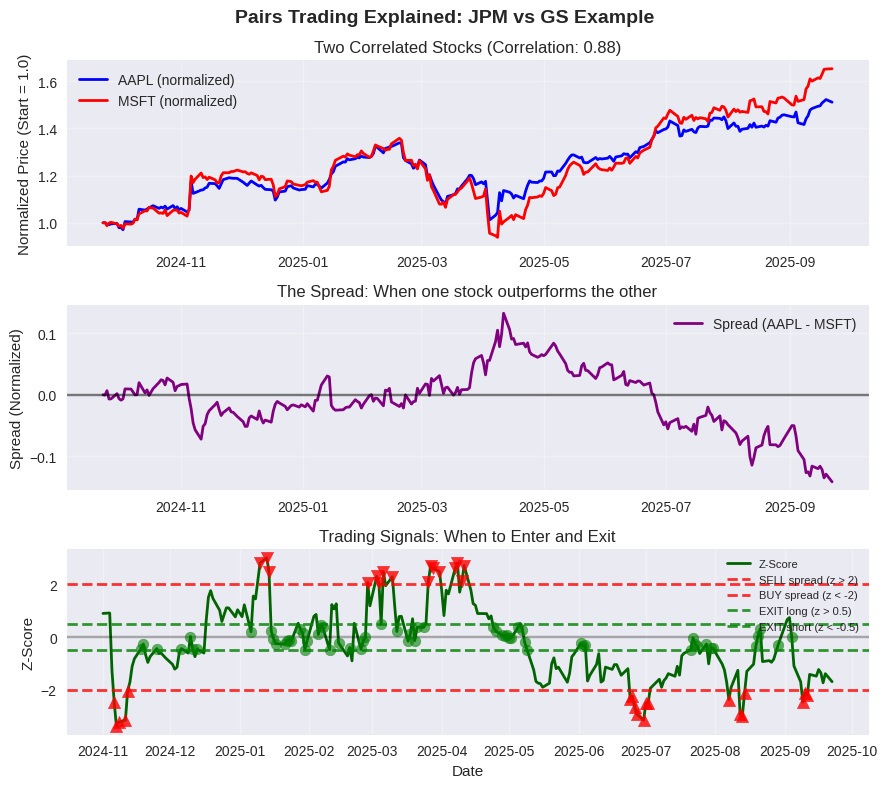

In [25]:
example_tickers = ['JPM', 'GS']
print(f"Downloading example data: {example_tickers}")
example_data = yf.download(example_tickers, period='1y', interval='1d')['Close']

stock_a = example_data['JPM'].dropna()
stock_b = example_data['GS'].dropna()

common_dates = stock_a.index.intersection(stock_b.index)
stock_a = stock_a.loc[common_dates]
stock_b = stock_b.loc[common_dates]

# Calculate correlation
correlation = stock_a.pct_change().corr(stock_b.pct_change())
print(f"AAPL-MSFT correlation: {correlation:.3f}")

# Run pairs trading strategy
returns, spread, zscore = backtest_pairs_strategy(stock_a, stock_b)

stock_a_norm = stock_a / stock_a.iloc[0]
stock_b_norm = stock_b / stock_b.iloc[0]

# Create plot
fig, axes = plt.subplots(3, 1, figsize=(9, 8))
fig.suptitle('Pairs Trading Explained: JPM vs GS Example', fontsize=14, fontweight='bold')

axes[0].plot(stock_a_norm.index, stock_a_norm.values, label='AAPL (normalized)', linewidth=2, color='blue')
axes[0].plot(stock_b_norm.index, stock_b_norm.values, label='MSFT (normalized)', linewidth=2, color='red')
axes[0].set_ylabel('Normalized Price (Start = 1.0)')
axes[0].set_title(f'Two Correlated Stocks (Correlation: {correlation:.2f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(spread.index, spread.values, color='purple', linewidth=2, label='Spread (AAPL - MSFT)')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1].set_ylabel('Spread (Normalized)')
axes[1].set_title('The Spread: When one stock outperforms the other')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(zscore.index, zscore.values, color='darkgreen', linewidth=2, label='Z-Score')
axes[2].axhline(y=2, color='red', linestyle='--', alpha=0.8, linewidth=2, label='SELL spread (z > 2)')
axes[2].axhline(y=-2, color='red', linestyle='--', alpha=0.8, linewidth=2, label='BUY spread (z < -2)')
axes[2].axhline(y=0.5, color='green', linestyle='--', alpha=0.8, linewidth=2, label='EXIT long (z > 0.5)')
axes[2].axhline(y=-0.5, color='green', linestyle='--', alpha=0.8, linewidth=2, label='EXIT short (z < -0.5)')
axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3)

entry_points = zscore[(zscore > 2) | (zscore < -2)]
exit_points = zscore[(zscore.abs() < 0.5) & (zscore.abs() > 0)]

entry_count = 0
for date, value in entry_points.items():
    if value > 2:
        axes[2].scatter(date, value, color='red', s=80, marker='v', zorder=5, alpha=0.8)
        if entry_count < 2:
            axes[2].annotate('SELL', (date, value), xytext=(5, 10), textcoords='offset points',
                            fontsize=8, color='red', fontweight='bold')
    elif value < -2:
        axes[2].scatter(date, value, color='red', s=80, marker='^', zorder=5, alpha=0.8)
    entry_count += 1
for date, value in exit_points.items():
    axes[2].scatter(date, value, color='green', s=60, marker='o', zorder=5, alpha=0.6)

axes[2].set_ylabel('Z-Score')
axes[2].set_xlabel('Date')
axes[2].set_title('Trading Signals: When to Enter and Exit')
axes[2].legend(loc='upper right', fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Cell 3 : Downloading stock by sector we want to test

In [2]:
# Define stocks by sectors
sectors = {
    'Tech': ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'AMD', 'CRM'],
    'Banking': ['JPM', 'BAC', 'WFC', 'GS', 'MS', 'C'],
    'Energy': ['XOM', 'CVX', 'COP', 'SLB'],
    'Consumer': ['KO', 'PEP', 'PG', 'JNJ'],
    'Auto': ['TSLA', 'F', 'GM']
}

# Create pairs within same sectors
pairs_to_test = []
for sector, stocks in sectors.items():
    for i in range(len(stocks)):
        for j in range(i+1, len(stocks)):
            pairs_to_test.append((stocks[i], stocks[j]))

print(f"Testing {len(pairs_to_test)} same-sector pairs")

all_tickers = list(set([ticker for pair in pairs_to_test for ticker in pair]))
print(f"Downloading data for {len(all_tickers)} stocks...")
all_data = yf.download(all_tickers, period='5y', interval='1d')['Close']
print(f"Data: {all_data.shape[0]} days, {all_data.shape[1]} stocks")

Testing 45 same-sector pairs


[*********************100%***********************]  23 of 23 completed

Data: 1255 days, 23 stocks


Cell 4 : Calculating Volatility & Pearson correlation coefficient


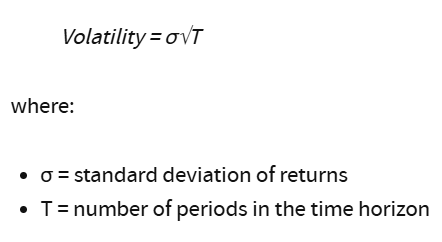

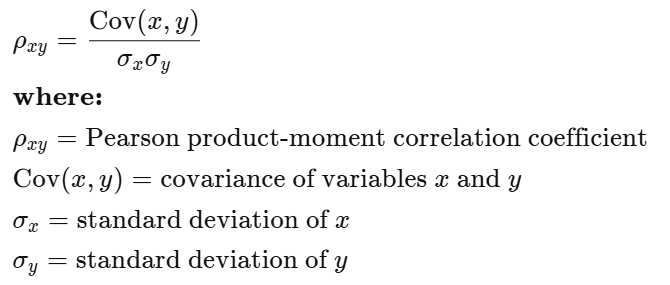



In [26]:
correlation_results = []

for ticker1, ticker2 in pairs_to_test:
    try:
        if ticker1 not in all_data.columns or ticker2 not in all_data.columns:
            continue

        stock_a = all_data[ticker1].dropna()
        stock_b = all_data[ticker2].dropna()

        common_dates = stock_a.index.intersection(stock_b.index)
        stock_a = stock_a.loc[common_dates]
        stock_b = stock_b.loc[common_dates]

        if len(stock_a) < 100:
            continue

        # Calculate real correlation
        correlation = stock_a.pct_change().corr(stock_b.pct_change())
        vol_a = stock_a.pct_change().std() * np.sqrt(252)
        vol_b = stock_b.pct_change().std() * np.sqrt(252)
        avg_volatility = (vol_a + vol_b) / 2

        correlation_results.append({
            'pair': f"{ticker1}-{ticker2}",
            'ticker1': ticker1,
            'ticker2': ticker2,
            'correlation': correlation,
            'avg_volatility': avg_volatility
        })

    except Exception:
        continue

corr_df = pd.DataFrame(correlation_results).sort_values('correlation', ascending=False)

# Auto-classify based on correlation thirds
high_threshold = corr_df['correlation'].quantile(0.67)
low_threshold = corr_df['correlation'].quantile(0.33)

def classify_correlation(corr):
    if corr >= high_threshold:
        return 'High'
    elif corr <= low_threshold:
        return 'Low'
    else:
        return 'Medium'

corr_df['category'] = corr_df['correlation'].apply(classify_correlation)

print(f"Calculated {len(corr_df)} correlations")
print(f"High (>{high_threshold:.2f}): {len(corr_df[corr_df['category']=='High'])} pairs")
print(f"Medium: {len(corr_df[corr_df['category']=='Medium'])} pairs")
print(f"Low (<{low_threshold:.2f}): {len(corr_df[corr_df['category']=='Low'])} pairs")

Calculated 45 correlations
High (>0.77): 15 pairs
Medium: 15 pairs
Low (<0.58): 15 pairs


Cell 5 : Showing returns of the pair trading strategy highliting correlation between the 2 stocks and volatility of the pair using :                                    


avg_volatility = (vol_a + vol_b) / 2


In [4]:
results = []

for _, row in corr_df.iterrows():
    try:
        stock_a = all_data[row['ticker1']].dropna()
        stock_b = all_data[row['ticker2']].dropna()

        common_dates = stock_a.index.intersection(stock_b.index)
        stock_a = stock_a.loc[common_dates]
        stock_b = stock_b.loc[common_dates]

        returns, spread, zscore = backtest_pairs_strategy(stock_a, stock_b)

        total_return = returns.sum()
        total_trades = len(returns[returns != 0])
        win_rate = len(returns[returns > 0]) / total_trades if total_trades > 0 else 0

        results.append({
            'pair': row['pair'],
            'category': row['category'],
            'correlation': row['correlation'],
            'avg_volatility': row['avg_volatility'],
            'total_return': total_return,
            'total_trades': total_trades,
            'win_rate': win_rate
        })

    except Exception:
        continue

results_df = pd.DataFrame(results)
print(f"Backtested {len(results_df)} pairs")

# Display results
print("\nTop 3 performers:")
top_5 = results_df.nlargest(3, 'total_return')[['pair', 'correlation', 'avg_volatility', 'total_return']]
top_5_display = top_5.copy()
top_5_display['avg_volatility'] = top_5_display['avg_volatility']
top_5_display.columns = ['pair', 'correlation', 'avg_vol(%)', 'total_return']
print(top_5_display.round(3))

print("\nPerformance by correlation level:")
summary = results_df.groupby('category')[['correlation', 'avg_volatility', 'total_return', 'win_rate']].mean().round(3)
summary_display = summary.copy()
summary_display['avg_volatility'] = summary_display['avg_volatility']
summary_display.columns = ['correlation', 'avg_vol(%)', 'total_return', 'win_rate']
print(summary_display)

Backtested 45 pairs

Top 3 performers:
          pair  correlation  avg_vol(%)  total_return
38   GOOGL-CRM        0.479       0.333         0.633
9      COP-SLB        0.777       0.380         0.604
29  AAPL-GOOGL        0.581       0.299         0.535

Performance by correlation level:
          correlation  avg_vol(%)  total_return  win_rate
category                                                 
High            0.804       0.300         0.076     0.641
Low             0.484       0.356        -0.322     0.616
Medium          0.696       0.295        -0.012     0.640


Cell 6 : Complete ranking of every pair by returns and volatility rank

In [12]:
print(f"\nCOMPLETE RANKING - All {len(results_df)} pairs:")
print("="*70)

ranking_df = results_df.copy()
ranking_df = ranking_df.sort_values('total_return', ascending=False).reset_index(drop=True)
ranking_df['vol_rank'] = ranking_df['avg_volatility'].rank(method='min').astype(int)
ranking_display = ranking_df[['pair', 'correlation', 'total_return', 'win_rate', 'avg_volatility', 'vol_rank']].copy()
ranking_display['avg_volatility'] = ranking_display['avg_volatility']
ranking_display['win_rate'] = ranking_display['win_rate']*100

ranking_display.columns = ['Pair', 'Correlation', 'Return', 'Win_Rate(%)', 'Vol(%)', 'Vol_Rank']
ranking_display.insert(0, 'Rank', range(1, len(ranking_display) + 1))

print(ranking_display.round(3).to_string(index=False))

print(f"\nVOLATILITY RANKING ANALYSIS:")
print(f"Top 5 performers avg vol rank: {ranking_df.head(5)['vol_rank'].mean():.1f}")
print(f"Bottom 5 performers avg vol rank: {ranking_df.tail(5)['vol_rank'].mean():.1f}")
print(f"Best performer vol rank: {ranking_df.iloc[0]['vol_rank']}")
print(f"Worst performer vol rank: {ranking_df.iloc[-1]['vol_rank']}")


COMPLETE RANKING - All 45 pairs:
 Rank       Pair  Correlation  Return  Win_Rate(%)  Vol(%)  Vol_Rank
    1    COP-SLB        0.777   0.654       74.359   0.380        33
    2 AAPL-GOOGL        0.582   0.553       68.571   0.299        22
    3  GOOGL-CRM        0.481   0.551       64.103   0.333        30
    4   MSFT-AMD        0.570   0.516       64.516   0.383        34
    5 MSFT-GOOGL        0.671   0.514       72.222   0.286        16
    6    BAC-WFC        0.823   0.407       65.789   0.300        23
    7     WFC-MS        0.714   0.372       69.444   0.304        24
    8  AAPL-MSFT        0.651   0.369       69.697   0.274        10
    9     KO-JNJ        0.478   0.311       71.429   0.166         1
   10      KO-PG        0.606   0.219       72.973   0.167         2
   11     BAC-GS        0.769   0.208       62.162   0.280        13
   12      BAC-C        0.823   0.196       66.667   0.290        19
   13       F-GM        0.767   0.171       65.714   0.384        35


Cell 7 : Final visualisation of how high volatility in pair trading can lower your returns

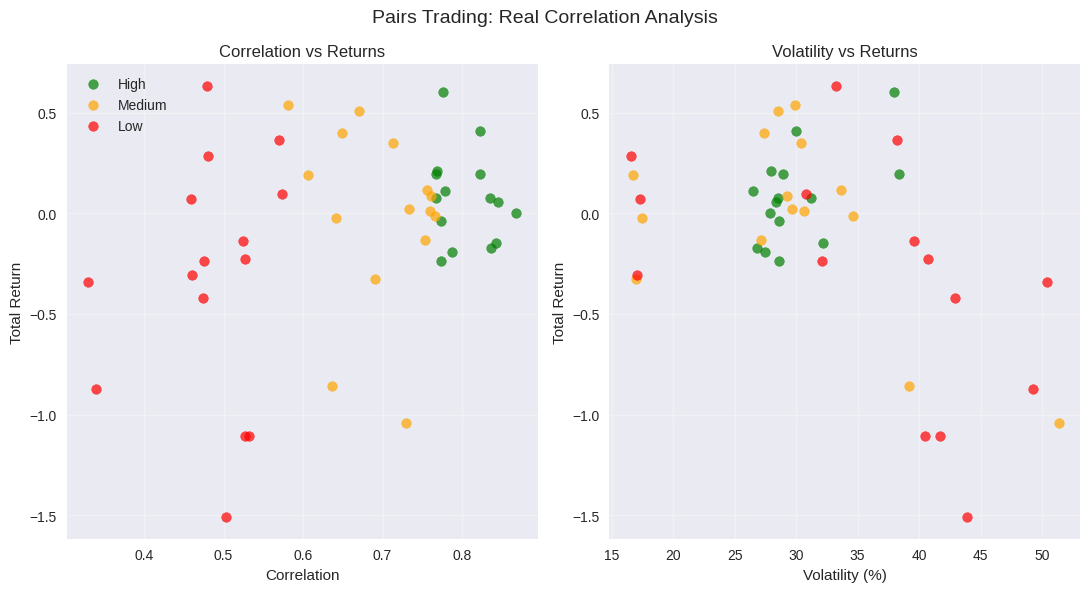

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(11, 6))
fig.suptitle('Pairs Trading: Real Correlation Analysis', fontsize=14)

# Correlation vs Returns
colors = {'High': 'green', 'Medium': 'orange', 'Low': 'red'}
for category in ['High', 'Medium', 'Low']:
    data = results_df[results_df['category'] == category]
    axes[0].scatter(data['correlation'], data['total_return'],
                      c=colors[category], label=category, alpha=0.7)
axes[0].set_xlabel('Correlation')
axes[0].set_ylabel('Total Return')
axes[0].set_title('Correlation vs Returns')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volatility vs Returns
for category in ['High', 'Medium', 'Low']:
    data = results_df[results_df['category'] == category]
    axes[1].scatter(data['avg_volatility'] * 100, data['total_return'],
                      c=colors[category], alpha=0.7)
axes[1].set_xlabel('Volatility (%)')
axes[1].set_ylabel('Total Return')
axes[1].set_title('Volatility vs Returns')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()